<div align="center">

### **EXAM #2 SIGNALS AND SYSTEMS - 2025 2S**
#### **Student:** Martín Ramírez Espinosa
##### Department of Electrical, Electronic and Computer Engineering
##### National University of Colombia - Manizales Campus

</div>

---

In [46]:
import numpy as np
import shutil
from pathlib import Path
from typing import Tuple, Optional
from yt_dlp import YoutubeDL
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from IPython.display import Audio, display

---

**1.** Consider the AM demodulator shown in the following figure:

<p align="center"><img src="demodulation-system.png" alt="AM demodulation diagram" style="max-width:100%; width:85%;"></p>

Assuming $\theta_0 = 0$, analytically derive the theoretical Fourier spectrum at each stage of the scheme. Then, take 5 seconds of a YouTube song as the message signal $m(t)$ and plot in the time and frequency domains the main stages of the modulation and demodulation process, playing the associated audio in each case. For the low-pass stage, implement an ideal filter in the frequency domain using the FFT.

In [47]:
def clear_cache(
        cache_dir: Optional[str] = None
) -> None:
    
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if not cache_path.exists() or not cache_path.is_dir():
        return

    for entry in cache_path.iterdir():
        if entry.name == ".gitignore":
            continue
        if entry.is_dir():
            shutil.rmtree(entry)
        else:
            entry.unlink()


def get_audio(
    url: str,
    start_s: float = 0.0,
    duration_s: float = 5.0,
    sample_rate_hz: int = 44100,
    cache_dir: Optional[str] = None,
    clean_cache: bool = True,
) -> Tuple[np.ndarray, int]:

    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if clean_cache:
        clear_cache(cache_path)
    cache_path.mkdir(parents=True, exist_ok=True)

    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": str(cache_path / "%(id)s.%(ext)s"),
        "quiet": True,
        "no_warnings": True,
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        audio_file = cache_path / f"{info['id']}.{info['ext']}"

    segment = AudioSegment.from_file(audio_file)
    start_ms = max(int(start_s * 1000), 0)
    end_ms = start_ms + int(duration_s * 1000)
    segment = segment[start_ms:end_ms].set_channels(1).set_frame_rate(sample_rate_hz)

    raw = np.asarray(segment.get_array_of_samples())
    samples = raw.astype(np.float32) / np.iinfo(raw.dtype).max
    return samples, sample_rate_hz

In [48]:
link = "https://www.youtube.com/watch?v=DraDpi4bM-Y"

In [49]:
msg_t, f_s = get_audio(link, start_s = 15.0)

In [50]:
def plot_domains(
        msg_t: np.ndarray,
        f_s: int
) -> None:
    
    N = len(msg_t)
    T_s = 1.0 / f_s
    t = np.linspace(0.0, N*T_s, N, endpoint=False)

    msg_f = fft(msg_t)
    f = fftfreq(N, T_s)[:N//2]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, msg_t, color='blue')
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.plot(f, 2.0/N * np.abs(msg_f[0:N//2]), color='red')
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

    display(Audio(msg_t, rate=f_s))


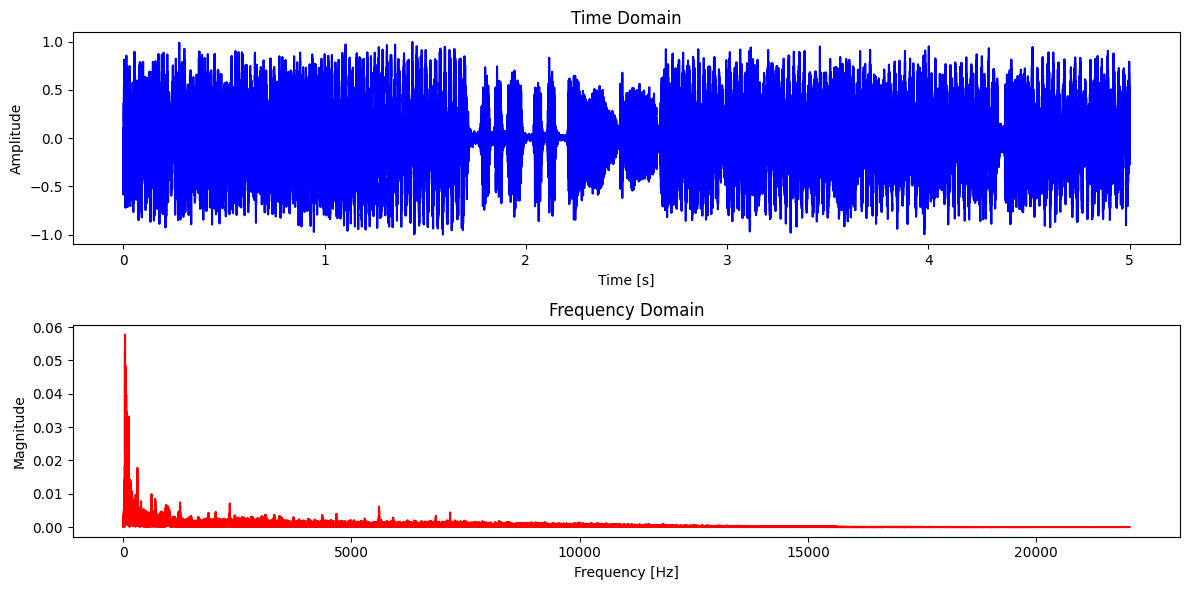

In [51]:
plot_domains(msg_t, f_s)

---

In [ ]:
def am_modulate(
        msg_t: np.ndarray,
        f_s: int,
        carrier_hz: float = 10000.0,
        modulation_index: float = 1.0
) -> np.ndarray:
    """Perform DSB-SC (carrier-suppressed) modulation on the message signal."""
    if modulation_index < 0:
        raise ValueError("modulation_index must be non-negative")

    message = np.asarray(msg_t, dtype=float)
    peak = np.max(np.abs(message))
    if peak == 0:
        return np.zeros_like(message)

    normalized_msg = message / peak
    t = np.arange(len(message)) / f_s
    carrier = np.cos(2 * np.pi * carrier_hz * t)
    return modulation_index * normalized_msg * carrier

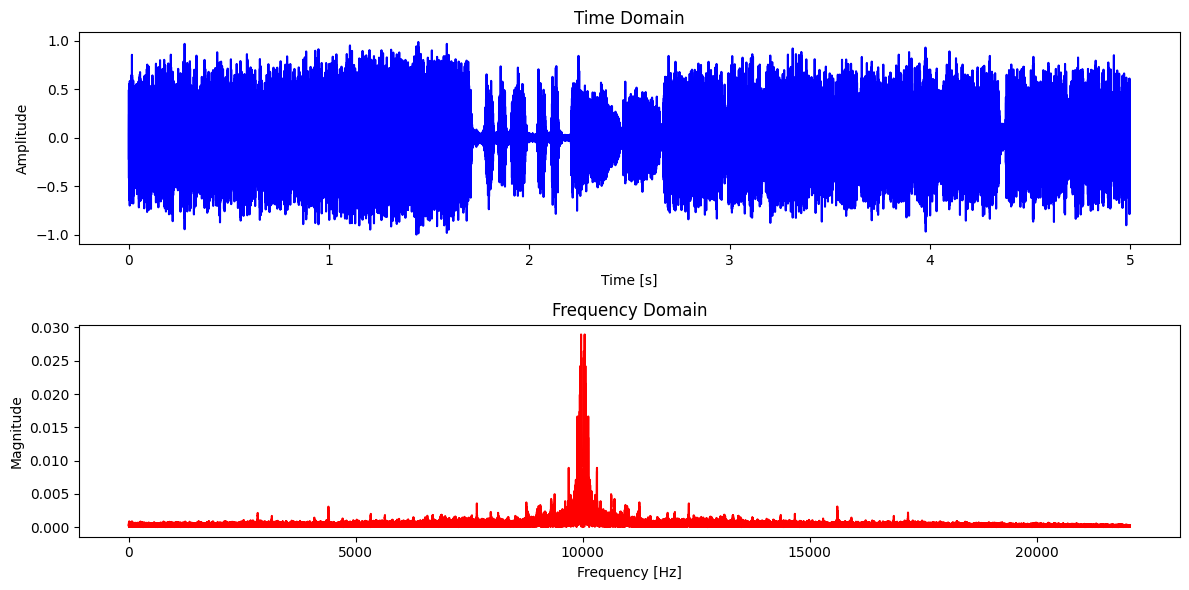

In [57]:
am_t = am_modulate(msg_t, f_s)
plot_domains(am_t, f_s)

---

**2.** Determine the transfer function that models the mass-spring-damper system shown in the following figure:

<p align="center"><img src="spring-mass-damper.png" alt="Mass-spring-damper system" style="max-width:70%; width:38%;"></p>

Next, obtain the equivalent model from the electrical circuit shown:

<p align="center"><img src="rlc-system.png" alt="Equivalent RLC circuit" style="max-width:80%; width:55%;"></p>

Propose numerical values for $m, k,$ and $c$ and their equivalents $R, L,$ and $C$ that allow you to simulate underdamped, overdamped, and critically damped regimes; for each case compute the damping ratio, the damped natural frequency, the undamped natural frequency, the peak time, the rise time, and the settling time. For each scenario, plot the pole-zero map, the Bode diagram, the impulse response, the step response, and the ramp response. Repeat the procedure for the closed-loop system.